In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image

import ultralytics
from ultralytics import YOLO
import pybboxes as pbx
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from shutil import copyfile

import tqdm 
tqdm.tqdm.pandas()

# ultralytics.checks()

In [2]:
IMAGE_DIR = '/home/nischay/ship-detection/train'

In [3]:
import glob
images = glob.glob(IMAGE_DIR+'/*')
images = sorted(images)
len(images)

257

In [4]:
## Making Train, Validation split

In [5]:
train_paths = images[:200]
valid_paths = images[200:]

In [6]:
train_df = pd.read_csv('train.csv')

In [7]:
train_df.head(5)

id    xmin    ymin    xmax    ymax
0  0.png  6690.0  3599.0  7164.0  3850.0
1  0.png  6772.0  3386.0  7039.0  3546.0
2  0.png  6705.0  3291.0  7060.0  3485.0
3  0.png  6230.0  3442.0  6597.0  3647.0
4  0.png  5501.0   790.0  5552.0   868.0

In [8]:
train_df['path'] = IMAGE_DIR + '/' + train_df['id'].astype(str)

In [9]:
train_df['class'] = 'ship'

In [10]:
def draw_box(train, num):
    
    idx = train.iloc[num]
    
    image = cv2.imread(idx['path'])
    H,W = image.shape[0],image.shape[1]
    file = idx['id']
    
    box=train[train['path']==idx['path']]
    box=box.reset_index(drop=True)

    for i in range(len(box)):
        label=box.loc[i,'class']
        x1=box.loc[i,'xmin']
        y1=box.loc[i,'ymin']
        x2=box.loc[i,'xmax'] 
        y2=box.loc[i,'ymax']
        
        x, y, w, h = pbx.convert_bbox((x1, y1, x2, y2,), from_type="voc", to_type="yolo", image_size=(W,H))
        
        x1 = int((x-w/2)*W)
        y1 = int((y-h/2)*H)#.astype(int)
        x2 = int((x+w/2)*W)#.astype(int)
        y2 = int((y+h/2)*H)#.astype(int)
#         print(x,y,w,h)
        if label=='ship':
            cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),5) #green

    return image

In [11]:
# a = draw_box(train_df, 10)

In [12]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [13]:
def create_animation(train_df, nums):    
    images = [draw_box(train_df,num) for num in nums]#[cv2.imread(i) for i in images]
    fig=plt.figure(figsize=(10,6))
    im=plt.imshow(cv2.cvtColor(images[0],cv2.COLOR_BGR2RGB))
    plt.close()    
    def animate_func(i):
        im.set_array(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
        return [im]
    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000//2)


## Visualize Images with True Labels

In [14]:
create_animation(train_df, nums = [0,100])

## Converting Dataset into Yolo Format

In [15]:
os.makedirs('datasets', exist_ok=True)
os.makedirs('datasets/train', exist_ok=True)
os.makedirs('datasets/valid', exist_ok=True)
os.makedirs('datasets/test', exist_ok=True)


In [16]:
MAKE_DIRS = False

In [17]:
if MAKE_DIRS:
    for path in tqdm.tqdm(train_paths):
        output_path = 'datasets/train'

        box=train_df[train_df['path']==path]
        box=box.reset_index(drop=True)
    #     idx = train.iloc[num]

        image = cv2.imread(box.loc[0,'path'])
        H,W = image.shape[0],image.shape[1]
        file = box.loc[0,'id']
        file_object = open(f"{output_path}/{file.split('.')[0]}.txt", "a")

        cv2.imwrite(f'{output_path}/{file}', image)

        for i in range(len(box)):
            label=box.loc[i,'class']
            x1=box.loc[i,'xmin']
            y1=box.loc[i,'ymin']
            x2=box.loc[i,'xmax'] 
            y2=box.loc[i,'ymax']

            x, y, w, h = pbx.convert_bbox((x1, y1, x2, y2,), from_type="voc", to_type="yolo", image_size=(W,H))


          # Writing current object 
            file_object.write(f"{0} {x} {y} {w} {h}\n")

        file_object.close()


In [18]:
## Validation data
if MAKE_DIRS:    
    for path in tqdm.tqdm(valid_paths):
        output_path = 'datasets/valid'

        box=train_df[train_df['path']==path]
        box=box.reset_index(drop=True)
    #     idx = train.iloc[num]

        image = cv2.imread(box.loc[0,'path'])
        H,W = image.shape[0],image.shape[1]
        file = box.loc[0,'id']
        file_object = open(f"{output_path}/{file.split('.')[0]}.txt", "a")

        cv2.imwrite(f'{output_path}/{file}', image)

        for i in range(len(box)):
            label=box.loc[i,'class']
            x1=box.loc[i,'xmin']
            y1=box.loc[i,'ymin']
            x2=box.loc[i,'xmax'] 
            y2=box.loc[i,'ymax']

            x, y, w, h = pbx.convert_bbox((x1, y1, x2, y2,), from_type="voc", to_type="yolo", image_size=(W,H))


          # Writing current object 
            file_object.write(f"{0} {x} {y} {w} {h}\n")

        file_object.close()


In [58]:
test_images = glob.glob('test/*')


In [19]:
if MAKE_DIRS:
    # len(test_images)
    for i in (test_images):
        path = (i.split('/')[-1])
        copyfile(i, f'datasets/test/{path}')

In [128]:
import yaml

train_yaml = dict(
    train ='train',
    val ='valid',
    test='test',
    nc =1,
    names =['ship',]
)

with open('train.yaml', 'w') as outfile:
    yaml.dump(train_yaml, outfile, default_flow_style=True)
    
%cat train.yaml

{names: [ship], nc: 1, test: test, train: train, val: valid}


In [129]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt") 


In [22]:
# !yolo task=detect mode=train model=yolov8n.pt data=train.yaml epochs=2 

In [130]:
# Training.

results = model.train(
   data='train.yaml',
   imgsz=720,
   epochs=10,
   batch=8,
   name='yolov8n_v1_10epoch_ship'
)

Ultralytics YOLOv8.0.49 🚀 Python-3.10.8 torch-1.13.1 CUDA:0 (NVIDIA RTX A6000, 48685MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=train.yaml, epochs=10, patience=50, batch=8, imgsz=720, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v1_10epoch_ship, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, 

## Check Validation Results

In [137]:
result_paths = glob.glob('runs/detect/yolov8n_v1_10epoch_ship/*jpg') +  glob.glob('runs/detect/yolov8n_v1_10epoch_ship/*png')

In [138]:
result_paths

['runs/detect/yolov8n_v1_10epoch_ship/val_batch2_labels.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/train_batch2.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/val_batch1_labels.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/train_batch0.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/val_batch1_pred.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/val_batch0_pred.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/labels.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/val_batch2_pred.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/train_batch1.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/labels_correlogram.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/val_batch0_labels.jpg',
 'runs/detect/yolov8n_v1_10epoch_ship/P_curve.png',
 'runs/detect/yolov8n_v1_10epoch_ship/PR_curve.png',
 'runs/detect/yolov8n_v1_10epoch_ship/F1_curve.png',
 'runs/detect/yolov8n_v1_10epoch_ship/results.png',
 'runs/detect/yolov8n_v1_10epoch_ship/confusion_matrix.png',
 'runs/detect/yolov8n_v1_10epoch_ship/R_curve.png']

In [139]:
result_paths = result_paths[-7:]

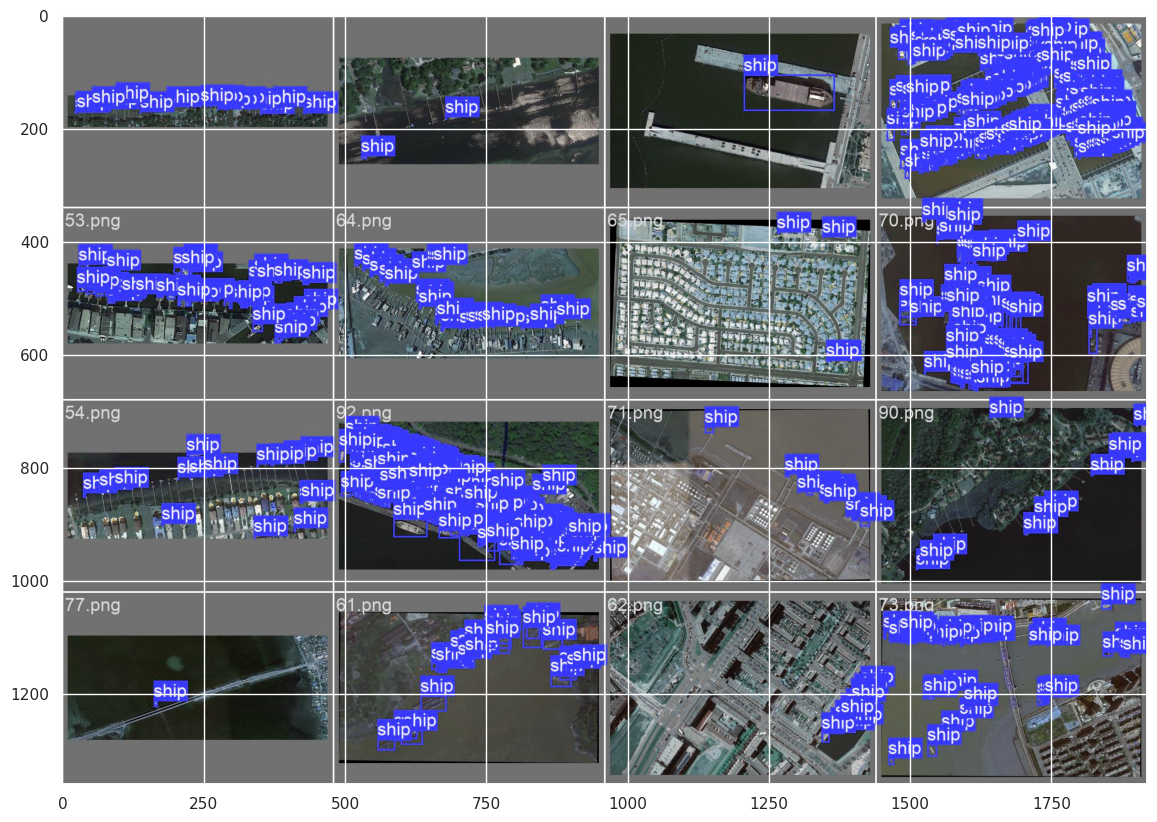

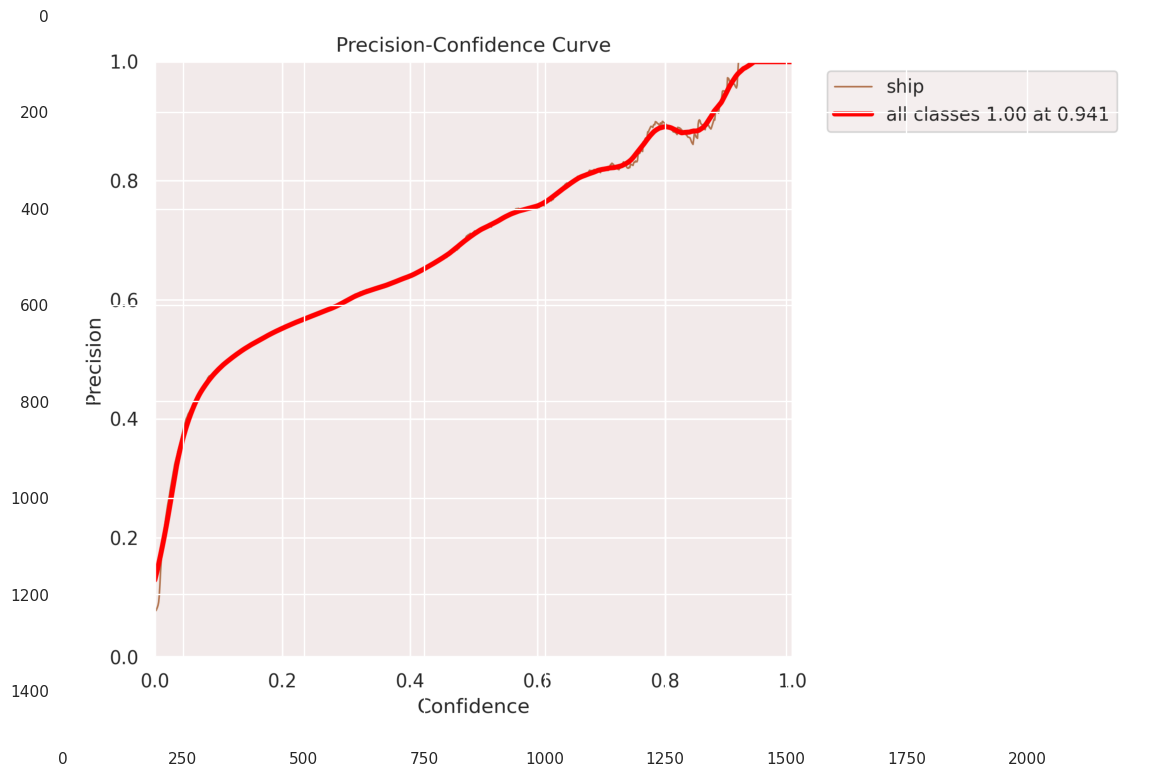

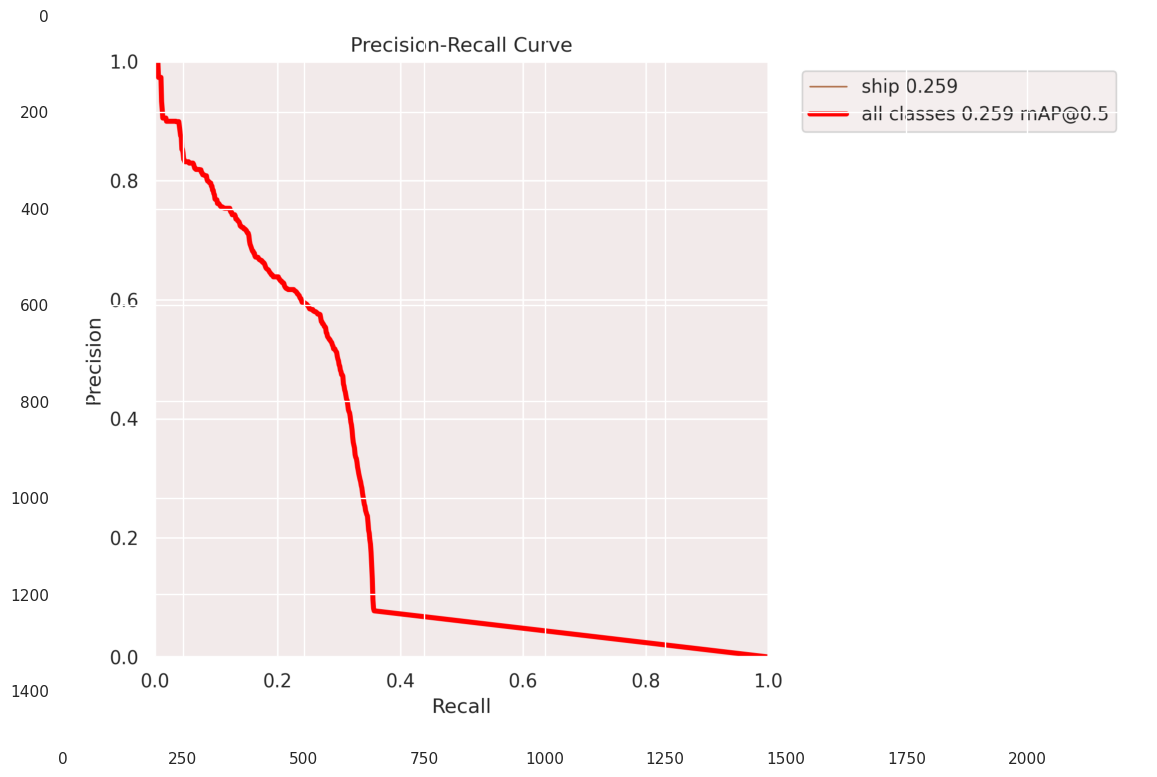

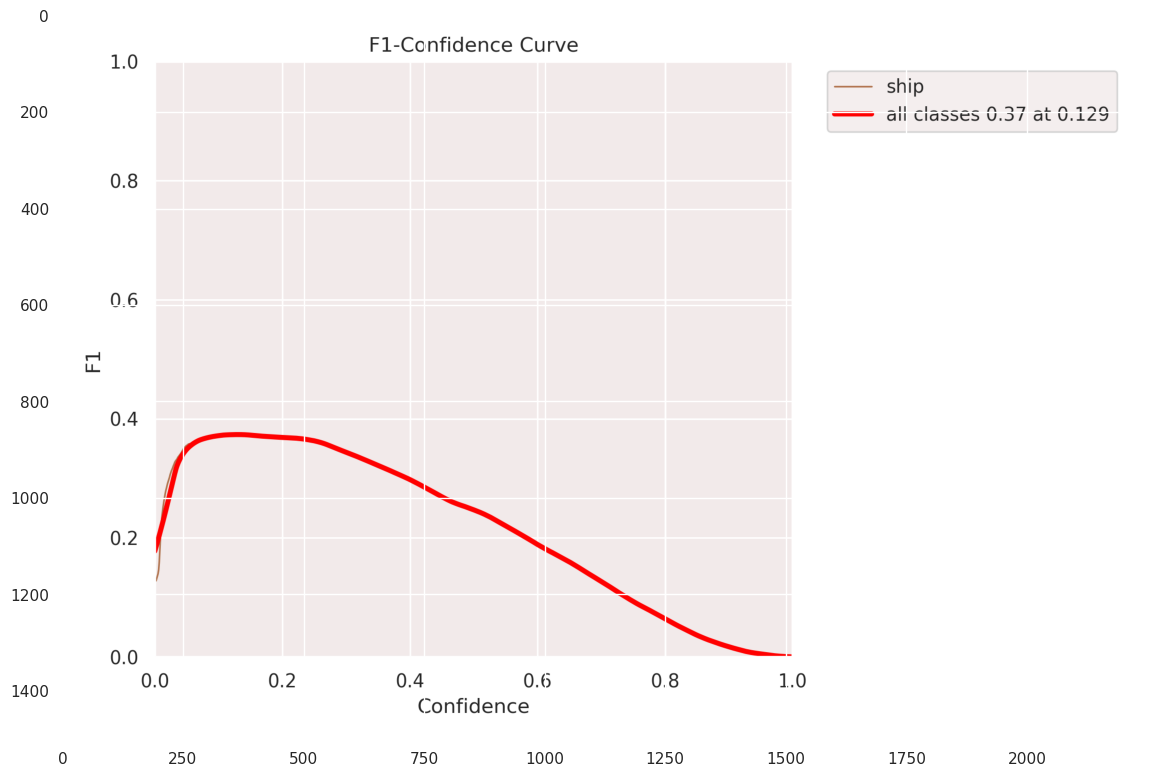

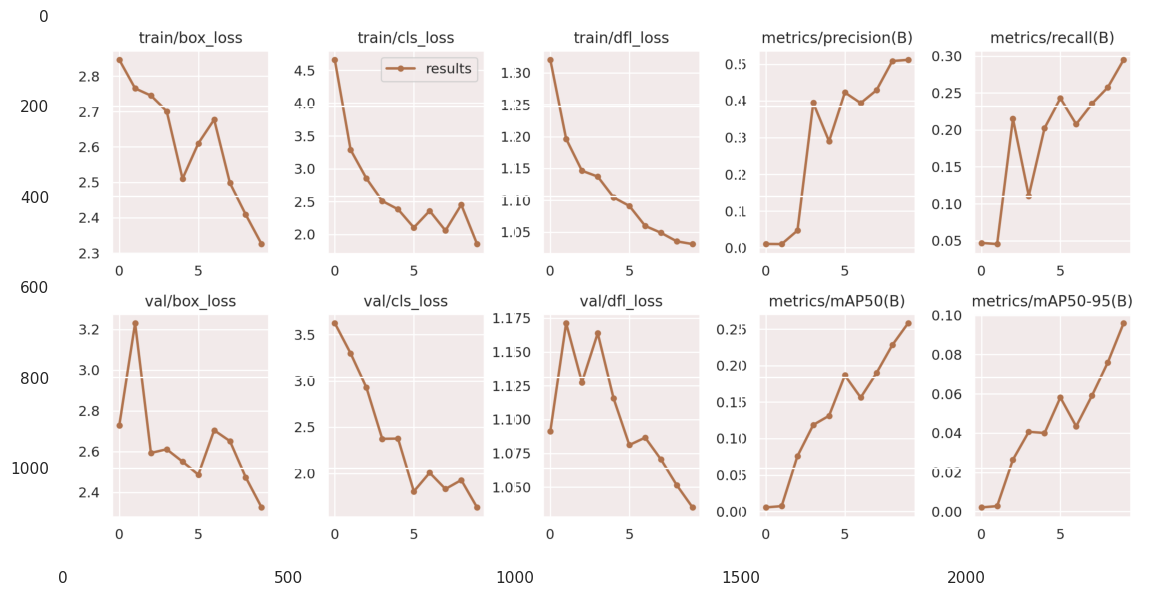

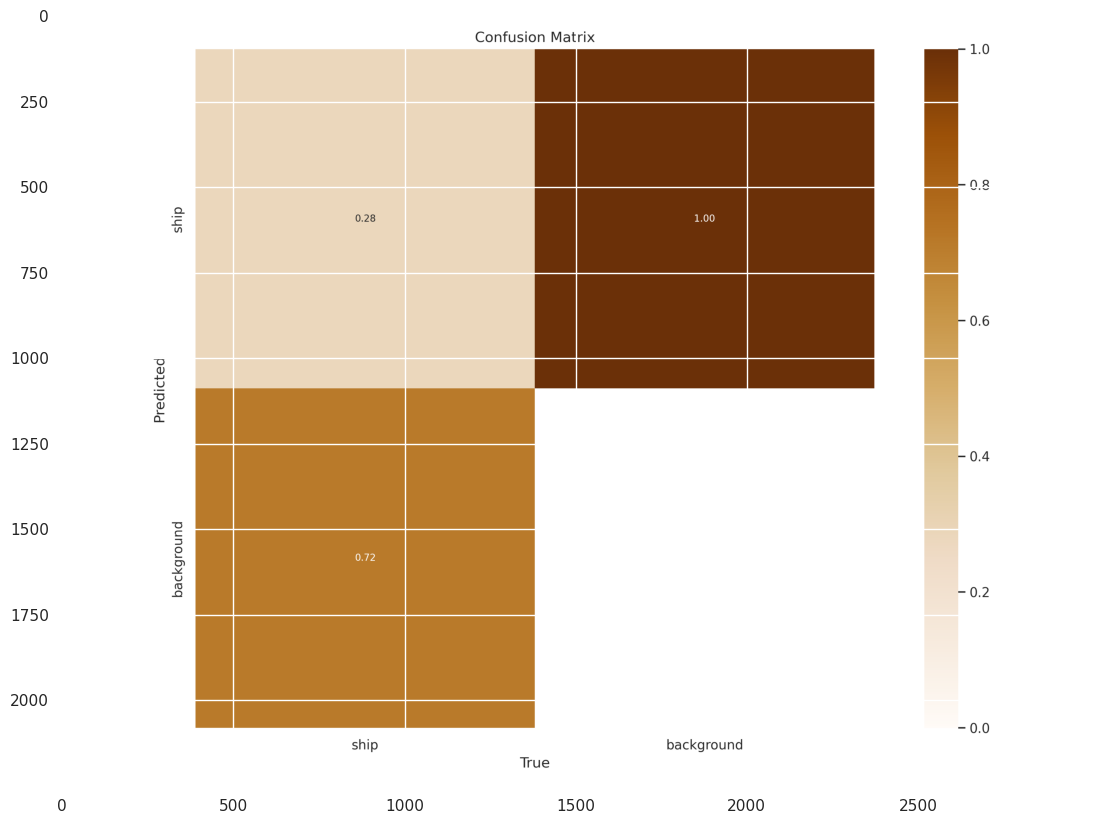

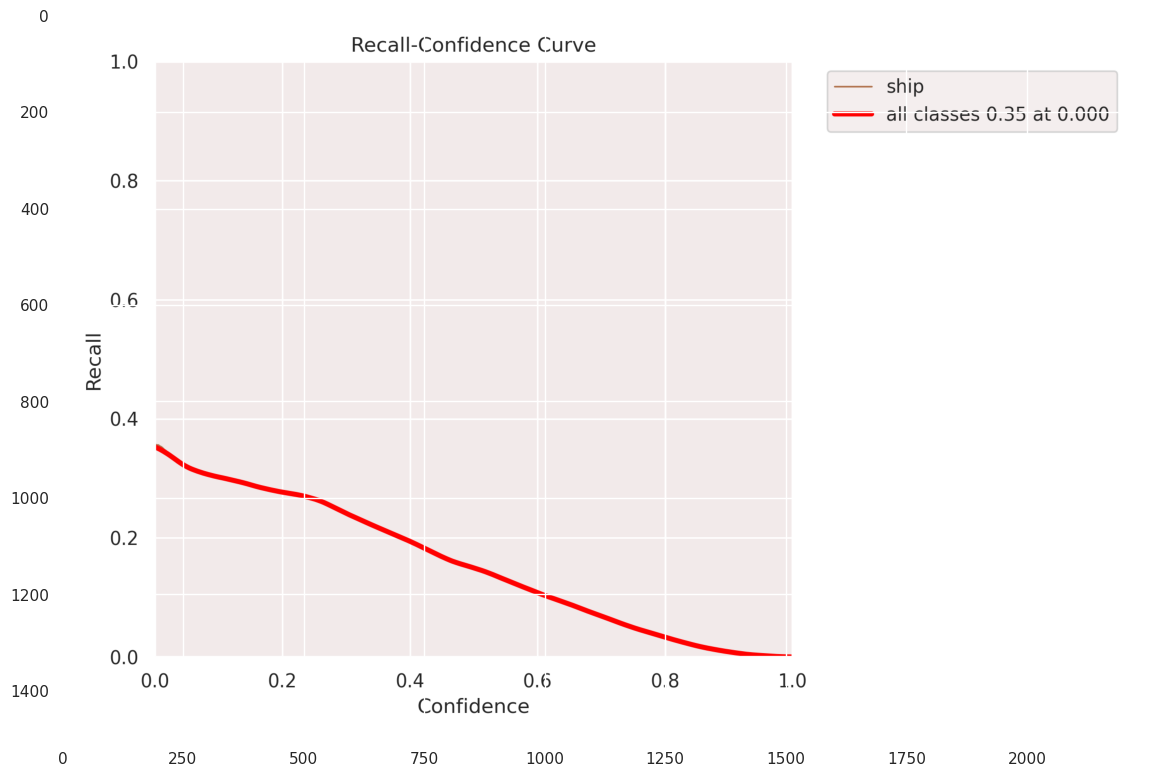

In [140]:
%matplotlib inline

for path in result_paths:
    image = cv2.imread(path)
    plt.figure(figsize=(14,10))
    plt.imshow(image)
    plt.show()

## Make Predictions using best model

In [141]:
model_best = YOLO('runs/detect/yolov8n_v1_10epoch_ship/weights/best.pt')


In [152]:
preds = model_best.predict(conf = 0.1, source = 'datasets/test/')

In [192]:
test_images_sort = [f'test/{i}.png' for i in range(386)]

In [191]:
len(test_images)

386

In [193]:
len(test_images)

386

In [194]:
test_preds = pd.DataFrame(columns=range(6))
for i in range(len(preds)):
    arri = pd.DataFrame(preds[i].boxes.boxes.cpu()).astype(float)
    path = test_images_sort[i]
    file = path.split('/')[-1]
    arri = arri.assign(file=file)
    arri = arri.assign(i=i)
    test_preds = pd.concat([test_preds,arri],axis=0)
test_preds.columns = ['xmin','ymin','xmax','ymax','confidence','class','id','i']
display(test_preds)

xmin    ymin    xmax    ymax  confidence  class       id      i
0     39.0   190.0    65.0   209.0    0.190871    0.0    0.png    0.0
1    899.0   819.0   928.0   839.0    0.183995    0.0    0.png    0.0
2    795.0   614.0   818.0   641.0    0.169300    0.0    0.png    0.0
3    900.0   826.0   929.0   848.0    0.132898    0.0    0.png    0.0
4    283.0   298.0   341.0   317.0    0.128759    0.0    0.png    0.0
..     ...     ...     ...     ...         ...    ...      ...    ...
70  2640.0  5170.0  2740.0  5252.0    0.102205    0.0  384.png  384.0
71  2227.0  5472.0  2299.0  5545.0    0.101555    0.0  384.png  384.0
72  2411.0  5949.0  2490.0  6038.0    0.101010    0.0  384.png  384.0
73  2576.0  5624.0  2636.0  5693.0    0.100681    0.0  384.png  384.0
74  3222.0  5613.0  3314.0  5714.0    0.100539    0.0  384.png  384.0

[19605 rows x 8 columns]

In [195]:
test_preds['class'].value_counts()

0.0    19605
Name: class, dtype: int64

In [196]:
test_preds = test_preds[["id","xmin","ymin","xmax","ymax","confidence"]].reset_index(drop=True)

In [197]:
test_preds.id.nunique()

314

In [198]:
sample_sub = pd.DataFrame([i.split('/')[-1] for i in test_images],columns=["id"]).reset_index(drop=True)
sample_sub["label"] = "0 0 0 10 10"

In [199]:
sample_sub

id        label
0     77.png  0 0 0 10 10
1     38.png  0 0 0 10 10
2    212.png  0 0 0 10 10
3    275.png  0 0 0 10 10
4    133.png  0 0 0 10 10
..       ...          ...
381  289.png  0 0 0 10 10
382   59.png  0 0 0 10 10
383  270.png  0 0 0 10 10
384  371.png  0 0 0 10 10
385  155.png  0 0 0 10 10

[386 rows x 2 columns]

In [200]:
# Convert detections to string format

for i in tqdm.tqdm(range(len(sample_sub))):
    detections = []
    idd = sample_sub.loc[i,'id']
    df = test_preds[test_preds['id']==idd]
#     print(len(df))
    for i, row in df.iterrows():
        detection_str = f"{row['confidence']} {int(row['xmin'])} {int(row['ymin'])} {int(row['xmax'])} {int(row['ymax'])}"
        detections.append(detection_str)
    detections_str = ', '.join(detections)
    idx = list(sample_sub[sample_sub['id']==idd].index)
    if len(df)>0:
        sample_sub.loc[idx,"label"] = detections_str
#     break

100%|█████████████████████████████████████████████████████████████| 386/386 [00:01<00:00, 277.46it/s]


In [201]:
sample_sub

id                                              label
0     77.png  0.8992375135421753 1884 593 1971 630, 0.874583...
1     38.png  0.27340584993362427 1966 2108 2123 2327, 0.195...
2    212.png  0.8079485297203064 367 301 412 354, 0.80148148...
3    275.png                                        0 0 0 10 10
4    133.png              0.12223257124423981 3126 528 3156 560
..       ...                                                ...
381  289.png                                        0 0 0 10 10
382   59.png  0.9521473050117493 713 700 776 746, 0.93870586...
383  270.png  0.19160722196102142 669 3298 757 3375, 0.16991...
384  371.png  0.8329010009765625 2298 2051 2448 2206, 0.8196...
385  155.png  0.9560836553573608 232 823 339 901, 0.94576185...

[386 rows x 2 columns]

In [207]:
# sample_sub.loc[0,'label']

In [203]:
sample_sub.to_csv('submission.csv',index=False)

In [204]:
test_preds['path'] = 'test/' + test_preds['id']
test_preds['class'] = 'ship'

In [205]:
test_preds

id    xmin    ymin    xmax    ymax  confidence          path class
0        0.png    39.0   190.0    65.0   209.0    0.190871    test/0.png  ship
1        0.png   899.0   819.0   928.0   839.0    0.183995    test/0.png  ship
2        0.png   795.0   614.0   818.0   641.0    0.169300    test/0.png  ship
3        0.png   900.0   826.0   929.0   848.0    0.132898    test/0.png  ship
4        0.png   283.0   298.0   341.0   317.0    0.128759    test/0.png  ship
...        ...     ...     ...     ...     ...         ...           ...   ...
19600  384.png  2640.0  5170.0  2740.0  5252.0    0.102205  test/384.png  ship
19601  384.png  2227.0  5472.0  2299.0  5545.0    0.101555  test/384.png  ship
19602  384.png  2411.0  5949.0  2490.0  6038.0    0.101010  test/384.png  ship
19603  384.png  2576.0  5624.0  2636.0  5693.0    0.100681  test/384.png  ship
19604  384.png  3222.0  5613.0  3314.0  5714.0    0.100539  test/384.png  ship

[19605 rows x 8 columns]

In [ ]:
create_animation(test_preds, nums = [16000,4000])